<a href="https://colab.research.google.com/github/Approach-Analytics/Emotion-Classifier/blob/main/Fear_Train_Refactor_RNN_80acc_Feb17_%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Refactoring the code for RNN training 

##Want as few training steps as possible...

##Source of [codebook](https://katoch.medium.com/twitter-emotion-recognition-using-rnn-d3cd59862957)

Data source: 

df=pd.read_csv("/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Emotion datasets/fear_arousal_first2000books_w400.csv")

Shape: (151724, 4)

#Key results...Feb 8,2023


1.  With a 50% decrease in sample size - we get a 6% drop in accuracy? From about 70% to 76%. 
2.  Could we get to 80% accuracy with a larger sample size? 
3. What about 75% of the dataset - 72.65% and with 25% -> 59.3%
4. 121K -> 78%



In [1]:
#Need pip install tensorflow with...Jupyter Notebook

!pip install nlp
#!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 6.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


In [3]:
#Dec 7, 2022: Not sure what this piece of code is used for... 

import warnings
warnings.filterwarnings('ignore')

##Importing the dataset.. 

In [4]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Load dataset for the 

#/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Emotion datasets/fear_arousal_first2000books_w400.csv

df=pd.read_csv("/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Emotion datasets/fear_arousal_first2000books_w400.csv")

In [6]:
print(df.shape)
df.head(5)

(151724, 4)


,Unnamed: 0,text,emotion1,emotion2
0,0,of a safe next instant the street was empty ba...,panic,dread
1,1,aw now horn and pelt our peoples melt in cover...,dread,dread
2,2,an unwatched flame brightened for a moment an...,dread,dread
3,3,sign turn thee from thy morning mist or twili...,dread,dread
4,4,nted hathi oh but my tusks were red at bhurtpo...,horror,dread


In [7]:
#What emotion categories do we have? 

print(df['emotion1'].value_counts())

print(df['emotion2'].value_counts())

fear           35438
afraid         19448
anxious        10561
calm            9192
concerning      8439
anxiety         7629
frightened      7498
horror          7451
concerned       7416
dread           6722
fearful         5134
concern         4422
peaceful        4043
worry           3604
fright          3286
worried         2691
serene          2640
panic           2582
horrified       1697
frightening     1035
worrying         784
angst             12
Name: emotion1, dtype: int64
fear       71839
concern    20277
dread      18452
anxiety    18202
calm       15875
worry       7079
Name: emotion2, dtype: int64


In [8]:
#Relabelling a column... if needed... 

df.rename(columns={"emotion2": "label"},inplace =True)

In [9]:
#Let's see if we have missing values...No missing values... 

df.isna().sum()

Unnamed: 0    0
text          0
emotion1      0
label         0
dtype: int64

#Replacing the emotion words in the dataset.. 

In [10]:
#Generate all the unique emotion words that then get replaced... 

a = df['emotion1'].unique().tolist()

#The list a is our list of variable responses from the dataset... 
keyword = "emotions"
words = a
for j in words: 
  df['text'] = df['text'].str.replace(j,keyword)

##Frequency of emotion words per string

In [11]:
#Let's count the frequency of teh emotion words... 

text_column = df["text"]

#Define the word to count 

word_counts = text_column.str.count(keyword)

#Apply the variable back to the dataframe

df["emo_word_count"] = word_counts                                

In [12]:
#Let's look at the value counts of this thing

df["emo_word_count"].value_counts()

#print(df.shape)

1     98996
2     23512
4      8555
5      7464
3      5707
6      2509
10      832
11      830
7       805
12      617
13      529
9       399
8       377
14      204
15      170
16       79
17       44
18       33
19       24
21       15
20       13
22        6
23        2
25        1
28        1
Name: emo_word_count, dtype: int64

##Subsetting the data with 2 or less emotion words 

In [13]:
# define the emotion word and the frequency threshold
#emotion_word = 'emotions' 
#frequency_threshold = 2

# subset the dataframe based on the frequency of the emotion word
#df = df[df['text'].str.count(emotion_word) <= frequency_threshold]

In [14]:
#Let's check the size of this dataset to make sure the splice worked...

df.shape

(151724, 5)

#Sampling and shuffling the dataset... 

In [15]:
#Shuffling and sampling the dataset... this works... 
#0.5 means half the dataset is used

df = df.sample(frac=1)

#Vocab Size and Truncating the string

This step is important to make sure, there are no "chopped" words the NLTK collocation seems to just chop words. 

In [16]:
df.columns

Index(['Unnamed: 0', 'text', 'emotion1', 'label', 'emo_word_count'], dtype='object')

##Counting vocab size prior to mods

In [17]:
#Total vocabulary size prior to truncation 

from tensorflow.keras.preprocessing.text import Tokenizer

# convert the text into a list
text = df['text'].tolist()

# create a Tokenizer object
tokenizer = Tokenizer()

# fit the tokenizer on the text data
tokenizer.fit_on_texts(text)

# calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [18]:
#How big is the vocabulary size? 

vocab_size

129829

##Cutting a single word off either side of string - var: "text_minus1" 

###Feb 4: Need to test this - is the word count minus 2? 

In [19]:
#Cutting a single word off of both ends... 

def truncate_words(text, n=1):
    words = text.split()
    return ' '.join(words[n:-n])

df['text_minus1'] = df['text'].apply(lambda x: truncate_words(x))

##Filter out the rare words - threshold value is 2 

In [20]:
#Creating a function to filer rare words of data 
#Or do it for, df["text_minus1"]

from collections import Counter

def filter_rare_words(data, threshold=2):
    # Create a list of all words in the dataset
    words = [word for line in data.text for word in line.split()]
    
    # Use Counter to calculate the frequency of each word
    word_counts = Counter(words)
    
    # Create a set of words that occur more than the threshold number of times
    common_words = set([word for word, count in word_counts.items() if count >= threshold])
    
    # Filter out the rare words from each text sample
    filtered_data = data.copy()
    filtered_data['text'] = filtered_data['text'].apply(lambda x: " ".join([word for word in x.split() if word in common_words]))
    
    return filtered_data, word_counts


In [21]:
#Applying the function to filter the dataframe 

# Apply the filter_rare_words function to the 'text' column
filtered_data, word_counts = filter_rare_words(df, threshold=2)

# Create a new variable 'filtered_text' from the 'text' column of filtered_data
#I think we need this variable: text_minus1
filtered_text = filtered_data['text_minus1']

# Add the filtered_text variable as a new column in the original data DataFrame
df['filtered_text_minus1'] = filtered_text


#Vocab size after processing 

In [22]:
#Counting the word frequency again...
#Different variables: df['filtered_text'], df['text_minus1']

# convert the text into a list
text = df['filtered_text_minus1'].tolist()

# create a Tokenizer object
tokenizer = Tokenizer()

# fit the tokenizer on the text data
tokenizer.fit_on_texts(text)

# calculate the vocabulary size
vocab_size_minus1 = len(tokenizer.word_index) + 1

In [23]:
#Checking the value of the number 

vocab_size_minus1

113162

##Not in use: Truncating length of rows based on max word length...

Yes, the modified truncate_text function will remove words from both ends of the text to make it fit within the max_length limit.

The function calculates the number of words to keep in the truncated text by subtracting max_length from the total number of words, then dividing the result by 2 and using the floor division operator // to round down to the nearest integer. This gives the number of words to remove from each end of the text.

The function then searches for the nearest word boundary before the end index and after the start index, as described in my previous answer, to ensure that the truncated text contains complete words.

So, depending on the length of the original text and the max_length limit, some words may be removed from both ends of the text in order to create the truncated version. However, the function tries to minimize the number of words that are removed, and ensures that the truncated text contains complete words. 

In [24]:
# Select the column containing the text data
text_column = df['text']

# Function to truncate text
def truncate_text(text, max_length):
    words = text.split()
    if len(words) > max_length:
        start_index = (len(words) - max_length) // 2
        end_index = start_index + max_length
        # find the nearest word boundary before the end index
        while end_index < len(words) and not words[end_index-1].endswith('.'):
            end_index -= 1
        # find the nearest word boundary after the start index
        while start_index > 0 and not words[start_index].endswith('.'):
            start_index += 1
        truncated_words = words[start_index:end_index]
        truncated_text = ' '.join(truncated_words)
        return truncated_text
    else:
        return text

# Define a new variable to truncate the text in each row to max_length words
max_length = 50
df['truncated_text'] = text_column.apply(lambda x: truncate_text(x, max_length))


IndexError: ignored

##Length of text columns 

In [25]:
# This works as intended
text_column = df["text"]
trunc_text = df['text_minus1']

# Split the text in each row into words
def split_text(text):
    words = text.split()
    return len(words)

#Applying the function to count the words in both the pre and and post truncated text

df["word_count"] = text_column.apply(split_text)
df["text1_count"] = trunc_text.apply(split_text)


In [26]:
#Testing the frequency of words per row 

print(df["word_count"].describe())
print(df["text1_count"].describe())

count    151724.000000
mean         77.097901
std           5.668543
min          31.000000
25%          73.000000
50%          77.000000
75%          81.000000
max         135.000000
Name: word_count, dtype: float64
count    151724.000000
mean         75.097901
std           5.668543
min          29.000000
25%          71.000000
50%          75.000000
75%          79.000000
max         133.000000
Name: text1_count, dtype: float64


In [27]:
#Let's see what the DataFrame looks like 
df.columns

Index(['Unnamed: 0', 'text', 'emotion1', 'label', 'emo_word_count',
       'text_minus1', 'filtered_text_minus1', 'word_count', 'text1_count'],
      dtype='object')

In [ ]:
#Plot the histograms of word counts before and after truncation
#plt.hist(df["word_count"],bins=50, alpha=0.5, label="Before Truncation")
#plt.hist(df["truncated_word_count"],bins=50, alpha=0.5, label="After Truncation")
#plt.legend()
#plt.show()

# Splitting into train, validate and test datasets
---


In [ ]:
df.shape

In [28]:
#This seems to be hte simplest way to do the 3 way training split...
#And then this outputs 3 different dataframes... originally 0.6 and 0.8

train, validate, test = np.split(df, 
                       [int(.8*len(df)), int(.9*len(df))])

In [29]:
#Checking to make sure that all three are dataframes... 

type(train),type(validate),type(test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [30]:
#Let's try to look at the proportion here... 

print(train.shape)
print(test.shape)
print(validate.shape)

(121379, 9)
(15173, 9)
(15172, 9)


# 6. Preparing the Labels

## In terms of sequence, I think this should go right below the dataframe -> List code

In [31]:
#Converting the pandas dataframe into a list of labels... 
#We may consider puting this into a function... 

trainlabel=train['label'].tolist()
vallabel=validate['label'].tolist()
testlabel=test['label'].tolist()

{'concern', 'dread', 'calm', 'worry', 'anxiety', 'fear'}


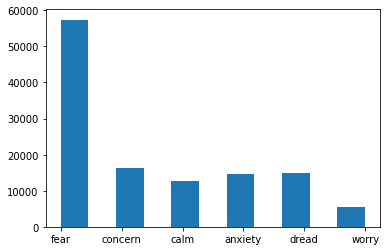

In [32]:
#Convert the labels into a a set(just unique values) and print them...
#Labels is a list... 

classes = set(trainlabel)
print(classes)

#What is the distribution of emotions in our literature? Histogram...  
#Bins 11 -> number of classifiers, with the number of spaces imbetween...

plt.hist(trainlabel, bins=11)
plt.show()

In [33]:
#One thing that ***I don't*** like about this way of doing things is that the ordering of the variables is a bit...!?!

classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [34]:
#This is simply a dictionary -> and it becomes an input into an 

classes_to_index

#Dec 12, I'm not sure what this is supposed to be for.. 

index_to_classes

{0: 'concern', 1: 'dread', 2: 'calm', 3: 'worry', 4: 'anxiety', 5: 'fear'}

In [35]:
#Creating a lambda function...called "names_to_ids"

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [36]:
#Applying the names_to_ids functions to the labels

train_labels = names_to_ids(trainlabel)
val_labels = names_to_ids(vallabel)
test_labels = names_to_ids(testlabel)

#Testing out the labels...
print(train_labels[10])

5


# 4. Input Training text and Tokenizing the Tweets
 

See reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)


In [37]:
#Converting the different pandas dataframes into a list of text fields...
#Choice of variables: truncated_text, text_minus1, 'filtered_text',''filtered_text_minus1'

traintext=train['filtered_text_minus1'].tolist()
valtext=validate['filtered_text_minus1'].tolist()
testtext=test['filtered_text_minus1'].tolist()

In [38]:
#What's the length of each of these things... 

print(len(traintext)),print(len(valtext)),print(len(testtext))

121379
15172
15173


(None, None, None)

In [39]:
#Importing the tokenizer...
#Input into the tokenizer is a list

from tensorflow.keras.preprocessing.text import Tokenizer

In [40]:
#Input into the tokenizer is a list

tokenizer = Tokenizer(num_words=113162, oov_token='<UNK>')

#I think that this is the missing piece...I'm not really sure what it does...  

tokenizer.fit_on_texts(traintext)
#tokenizer.fit_on_texts(valtext)

#Testing the tokenization... 

#print(tokenizer.texts_to_sequences([tweets[10]]))

## 5. Padding and Truncating Sequences

See this resource on padding sequence by Keras
https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
#Creating a function that tokenizes and pads the sequences...

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=400, padding='post')
    return padded_sequences

In [43]:
#Applying the function to tokenize and pad... to all test,validate and test
#Syntax: val_sequences = get_sequences(tokenizer, val_tweets)

padded_train_sequences = get_sequences(tokenizer, traintext)
val_sequence = get_sequences(tokenizer,valtext)
test_sequence = get_sequences(tokenizer,testtext)


# 7. Creating the Model

##Description of Hyperparameters 


1.   Embedding layer: nt in it? Words, X and input length...
2.   List item


In [53]:
#Embedding layer works on number of tokens -> approximately words... 
#Adding another layer: tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(500, return_sequences=True)),

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(113162, 500, input_length=400),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 500)          56581000  
                                                                 
 bidirectional_2 (Bidirectio  (None, 400, 400)         1121600   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              961600    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 2406      
                                                                 
Total params: 58,666,606
Trainable params: 58,666,606
Non-trainable params: 0
_________________________________________________________________






































## 8. Training the Model

In [54]:
#Having the callbacks option on means that the model stops once you are like over-generalizing... 
#Let's leave the callback option on for now...


h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
   ]
)

Epoch 1/3
3794/3794 [==============================] - 486s 126ms/step - loss: 0.9965 - accuracy: 0.6416 - val_loss: 0.6795 - val_accuracy: 0.7576
Epoch 2/3
3794/3794 [==============================] - 435s 115ms/step - loss: 0.5045 - accuracy: 0.8217 - val_loss: 0.5718 - val_accuracy: 0.7948
Epoch 3/3
3794/3794 [==============================] - 434s 114ms/step - loss: 0.2789 - accuracy: 0.9044 - val_loss: 0.6337 - val_accuracy: 0.7878


#9. Evaluating the model 

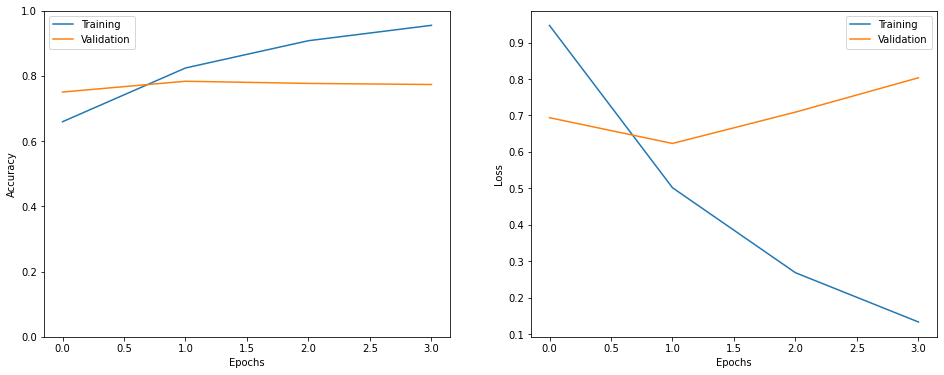

In [46]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [56]:
#Running the model on the test sequence and test labels... 

eval = model.evaluate(test_sequence, test_labels)

475/475 [==============================] - 19s 40ms/step - loss: 0.6201 - accuracy: 0.7958


In [55]:
#preds = model.predict_classes(test_sequence)
preds=model.predict(test_sequence) 
classes_x=np.argmax(preds,axis=1)
preds.shape, test_labels.shape

475/475 [==============================] - 20s 37ms/step


((15173, 6), (15173,))

In [58]:
#Creating an inference dataframe 

inf_df=pd.DataFrame({
    'data':testtext,
    "labels_predicted": classes_x                    
})
inf_df["labels_predicted_marked"]=inf_df['labels_predicted'].apply(lambda x: index_to_classes[x])
inf_df["actual_labels"]=testlabel

#Creating the labels index datastructure...

inf_df["actual_label_index"]=inf_df['actual_labels'].apply(lambda x: classes_to_index[x])

#Checking the data structure

#inf_df

In [59]:
#Making the correct prediction 

# marking the corrcet predictions.
inf_df['correct_pred']=0 # first assigning all to 0.
inf_df.loc[(inf_df['labels_predicted']==inf_df['actual_label_index']),'correct_pred']=1 # labelling 1 if the prediction is right.

In [60]:
# magnitutde of error
inf_df['error_magnitude']=abs(inf_df['labels_predicted']-inf_df['actual_label_index'])

In [ ]:
#creating a table of high level prediction scores 

inf_df1=pd.DataFrame(inf_df['correct_pred'].value_counts()).reset_index()
inf_df1

##Creating Histogram for Error Magnitude 

Text(0, 0.5, 'Frequency')

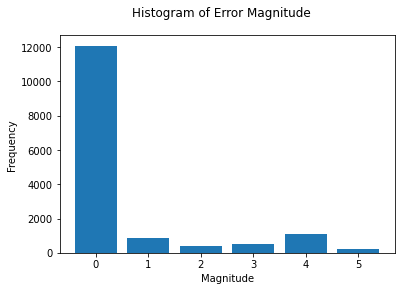

In [61]:
# Count the frequency of each class in the error_magnitude column
counts = inf_df['error_magnitude'].value_counts()

# Create a histogram with one bar for each class
plt.bar(counts.index, counts.values)

# Set the title and axis labels
plt.suptitle('Histogram of Error Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

In [ ]:
#Filtering error magnitude - if necessary...

inf_df[inf_df['error_magnitude']==5].head(10)

#Saving the model 

##Questions: At what point do we save the model...


1.   Resolve the character / length piece in looking at the inference dataset...
2.   I want the 75% run / run before I save it... 



In [52]:
#So this works but we need to make sure that we install Keras as a dependency 

from keras.models import load_model

model.save('/content/drive/MyDrive/Sean/Emoclass_Dec2022/Model_Fear_78acc_Feb17b,2022')